# Tweet classifier

In [26]:
# imports needed
import matplotlib.pyplot as plt
%matplotlib inline
import gensim 
import pandas as pd
import numpy as np
import random
import re
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from bs4 import BeautifulSoup
from  nltk.stem.snowball import FrenchStemmer, EnglishStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle
import dill as pickle
import unidecode
import sys
from help_dicrah_functions import *



import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# ML Tools
from sklearn import preprocessing, linear_model, svm, model_selection, ensemble
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, recall_score, make_scorer

import time
current_milli_time = lambda: int(round(time.time() * 1000))

import os
data_dir = '../data/'
models_dir = '/Volumes/MIchi Hard /models/' #'../models/'

Set the following global variables to choose the type of processing and set output file names

In [27]:
stem = True
remove_sw = True

if stem:
    stem_str = '_with_stem'
else:
    stem_str = '_no_stem'

    
if remove_sw:
    sw_str = '_sw_removed'
else:
    sw_str = '_no_sw_removed'


# Pre-process the sample to train w2v vectorizer


#### Estimate time to clean the full sample (don't run, just for info)

Text(0.5,0,'Sample size')

Text(0,0.5,'t [sec.]')

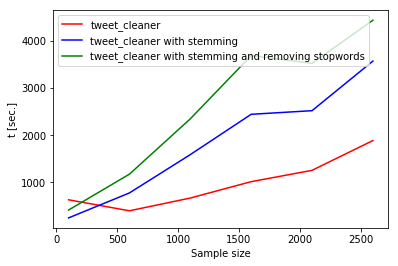

estimated time for 1M rows, tweet_cleaner = 26.49440201 min
estimated time for 1M rows,tweet_cleaner+stemming = 25.8495011933 min
estimated time for 1M rows, tweet_cleaner+stemming+remove_stopwords = 38.6279334092 min


In [28]:
dt1=[]
dt2=[]
dt3=[]
N = range(100,3000,500)

or_fname = 'tweets_dilcrah_keywords_1M.csv'
fname = data_dir+or_fname

df = pd.read_csv(fname, header=None)\
        .drop(0, axis=1)\
        .rename(columns={1: 'tweet'})



for n in N:
    dg=df.loc[:n]
    #dg = df.sample(n)

    # cleaning with tweet_cleaner
    t1 = current_milli_time()
    dg['clean_tweets'] = dg.tweet.apply(\
                                     lambda x:tweet_cleaner(x, my_dict, stem=False))
    
    # cleaning with tweet_cleaner + stemming
    t2 = current_milli_time()
    dg['clean_tweets_sw'] = dg.tweet.apply(\
                                           lambda x:tweet_cleaner(text, my_dict, stem=True))
    
    # cleaning with tweet_cleaner + stemming + removing stopwords
    t3 = current_milli_time()
    dg['clean_tweets_sw_stem'] = dg.tweet.apply(
        lambda x:' '.join(remove_stopwords(
                        tokenize(
                        tweet_cleaner(
                            text,
                            my_dict,
                            stem=True)),
                    generate_stopwords())))
    t4 = current_milli_time()

    dt1.append(t2-t1)
    dt2.append(t3-t2)
    dt3.append(t4-t3)


plt.plot(N, dt1, 'r', label='tweet_cleaner');
plt.plot(N, dt2, 'b', label='tweet_cleaner with stemming') ;
plt.plot(N, dt3, 'g', label='tweet_cleaner with stemming and removing stopwords');
plt.xlabel('Sample size');
plt.ylabel('t [sec.]');
plt.legend();
plt.show();

print("estimated time for 1M rows, tweet_cleaner =", 1000*np.mean(np.array(dt1)/np.array(N))/60,"min")
print("estimated time for 1M rows,tweet_cleaner+stemming =", 1000*np.mean(np.array(dt2)/np.array(N))/60,"min")
print("estimated time for 1M rows, tweet_cleaner+stemming+remove_stopwords =", 1000*np.mean(np.array(dt3)/np.array(N))/60,"min")




##### Pre-processing: example of usage and results

In [3]:
text = 'En effet, il a pas célébré https://t.co/fhwjTEyhMV'
print("Original: \n %s \n" %text)
t1 = tweet_cleaner(text, my_dict)
print("tweet_cleaner (no stemming): \n %s \n" %t1)
t2 = tweet_cleaner(text, my_dict, stem=True)
print("tweet_cleaner (with stemming): \n %s \n" %t2)
t3 = ' '.join(remove_stopwords(
                        tokenize(
                        tweet_cleaner(
                            text,
                            my_dict,
                            stem=True)),
                    generate_stopwords()))
print("tweet_cleaner (with stemming) +  remove_stopwords: \n %s \n" %t3)
t4 = tokenize(tweet_cleaner(text, my_dict))
print("Tokenization: \n %s \n" %t4)


Original: 
 En effet, il a pas célébré https://t.co/fhwjTEyhMV 

tweet_cleaner (no stemming): 
 en effet il a pas celebre 

tweet_cleaner (with stemming): 
 en effet il a pas celebr 

tweet_cleaner (with stemming) +  remove_stopwords: 
 effet celebr 

Tokenization: 
 ['en', 'effet', 'il', 'a', 'pas', 'celebre'] 



#### Clean the full sample and export

In [4]:
%%time

# in the file name, inlcude the type of pre-processing used! It must be the same as
# the one used to clean the labeled dataset
base_fname = 'tweets_dilcrah_keywords_1M_clean'
out_fname = base_fname+stem_str+sw_str+'.csv'

SAVED_DATASET = data_dir+out_fname

print("Path: "+SAVED_DATASET)

if not os.path.exists(SAVED_DATASET):
    
    print("Must clean dataset. Loading original...")
    
    or_fname = 'tweets_dilcrah_keywords_1M.csv'
    fname = data_dir+or_fname

    df = pd.read_csv(fname, header=None)\
        .drop(0, axis=1)\
        .rename(columns={1: 'tweet'})

  
    print("Cleaning dataset....")

    # takes ~10 mins to run
    if not remove_sw:
        df['clean_tweets'] = df.tweet.apply(lambda x:tweet_cleaner(x, my_dict, stem=stem)) 
    else:
        # takes ~20 mins to run
        df['clean_tweets'] = df.tweet.apply(lambda x:' '.join(remove_stopwords(
                        tokenize(
                        tweet_cleaner(
                            x,
                            my_dict,
                            stem=stem)),
                    generate_stopwords())))
    
    df = df.drop_duplicates(subset='clean_tweets')
    df.to_csv(SAVED_DATASET)

else:
    print("Loading clean dataset....")
    df = pd.read_csv(SAVED_DATASET)    
    # Apparently, some entries were saved as float (?). This function gest rid of the problem.
    def to_string(text):
        if type(text)==float:
            text = str(text)
        return text

    df['clean_tweets'] = df.clean_tweets.apply(lambda row: to_string(row))

    # Drop tweets with less than 2 words
    df['nc'] = [len(t) for t in df.clean_tweets]
    df['n_word'] = df['clean_tweets'].apply(lambda x: len(x.split(' ')))
    df = df.drop(df[df.nc <= 3].index).drop('nc', axis=1)
    df = df.drop(df[df.n_word <= 3].index).drop('n_word', axis=1)



print(df.shape)
df.head()

Path: ../data/tweets_dilcrah_keywords_1M_clean_with_stem_sw_removed.csv
Loading clean dataset....
(696505, 3)
CPU times: user 6.28 s, sys: 714 ms, total: 6.99 s
Wall time: 7.14 s


# w2v vectorizer

##### w2v model

In [5]:
%%time
# Parameters for w2v
num_features = 300    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
#downsampling = 1e-3   # Downsample setting for frequent words

base_model_name = 'saved_w2vec_1M'
full_model_name = base_model_name+stem_str+sw_str

SAVED_MODEL = models_dir+full_model_name+'_nf'+str(num_features)+'_mvc'+str(min_word_count)\
            +'_cont'+str(context)+'.pkl'#+'_ds'+str(downsampling)

print("Path: "+SAVED_MODEL)

if not os.path.exists(SAVED_MODEL):
    print("Traning model....")
    
    # Prepare a list of tokens as input for w2v
    documents = [tweet.split() for tweet in list(df['clean_tweets'])]
    # Takes ~8 mins to train with 300 features
    model_1M = gensim.models.Word2Vec(documents, 
                                      size=num_features, 
                                      window=context, 
                                      min_count=min_word_count,
                                      workers=4)
    model_1M.train(documents, total_examples=len(documents), epochs=10)
    with open(SAVED_MODEL, "wb") as f:
        pickle.dump(model_1M, f)
else:
    print("Loading model....")
    with open(SAVED_MODEL, "rb") as f:
        model_1M = pickle.load(f)
        
w2v_1M = dict(zip(model_1M.wv.index2word, model_1M.wv.syn0))

Path: /Volumes/MIchi Hard /models/saved_w2vec_1M_with_stem_sw_removed_nf300_mvc1_cont10.pkl
Loading model....
CPU times: user 1.54 s, sys: 1.37 s, total: 2.91 s
Wall time: 7.62 s


#### Fit tfIdf vectorizer to weight w2v vectors (SLOW)

In [6]:
%%time

base_vec_name = 'saved_w2vec_1M_vectorizer'
full_vec_name = base_vec_name+stem_str+sw_str


SAVED_1M_VEC= models_dir+full_vec_name+'_nf'+str(num_features)+'_mvc'+str(min_word_count)\
            +'_cont'+str(context)+'.pkl'#+'_ds'+str(downsampling)

print('Path: '+SAVED_1M_VEC)    
    
if not os.path.exists(SAVED_1M_VEC):

        print("Training vectorizer...")
        # building 1M vectorizer
        # Takes ~20 mins to train
        my_vectorizer_1M = TfidfEmbeddingVectorizer(w2v_1M)
        if remove_sw:
            my_vectorizer_1M.fit(df.clean_tweets, stem=stem, rem_sw=True)
        else:
            my_vectorizer_1M.fit(df.clean_tweets, stem=stem, rem_sw=False)
                
        with open(SAVED_1M_VEC, "wb") as f:
            pickle.dump(my_vectorizer_1M, f)

else:
        print("Loading vectorizer...")
        with open(SAVED_1M_VEC, "rb") as f:
            my_vectorizer_1M = pickle.load(f)


Path: /Volumes/MIchi Hard /models/saved_w2vec_1M_vectorizer_with_stem_sw_removed_nf300_mvc1_cont10.pkl
Loading vectorizer...
CPU times: user 1.6 s, sys: 581 ms, total: 2.18 s
Wall time: 3.5 s


# Machine Learning

##### pre-processing

In [7]:
data_path = data_dir+'tweets_labeled_4k_cleaned.csv'

tw_data = pd.read_csv(data_path)#.drop('id', axis=1).rename(columns={'label': 'Label', 'tweet': 'Texte'})

# Fix labels
labels = {'n':1, 'N':1, 'h':0, 'H':0, 'ENG':-1, 's':0, 
          'S':0, 'SH':0, 'PUB':-1, 'sh':0, 'f':-1, 'nn':1}

tw_data['Label'].replace(labels, inplace=True)
tw_data.drop(tw_data[tw_data.Label == -1].index, inplace=True) #removing ads etc.

# Clean text. Youc an choose whether to remove stopwords and stem.
# Note: use the same pre-processing used for the dataset on which w2v has been trained !
# In particular, here I don't remove stopwords, 
# since they could change substantially the meaning of a phrase

if not remove_sw:
    tw_data['Texte_clean'] = tw_data.Texte.apply(lambda x:tweet_cleaner(x, my_dict, stem=stem))
else:
    tw_data['Texte_clean'] = tw_data.Texte.apply(lambda x:' '.join(remove_stopwords(
                        tokenize(
                        tweet_cleaner(
                            x,
                            my_dict,
                            stem=stem)),
                    generate_stopwords())))



tw_data = tw_data.drop_duplicates(subset='Texte_clean')
tw_data = tw_data.dropna()


tw_data = tw_data.reset_index(drop=True)
tw_data['Label'].value_counts()
tw_data.head()

1.0    3090
0.0     545
Name: Label, dtype: int64

,Label,ID,Texte,Texte_clean
0,1.0,998206424189751296,On m’avait sorti (pour de vrai) « on est tous ...,av sort vrai tous egal plus parl racisme plus ...
1,1.0,997896508384169984,VIVE L AMOUR ❤VIVE LA PAIX\n❤❤❤❤❤❤❤❤❤❤❤❤👏👍\nEN...,viv amour viv paix entre peupl mond stop racis...
2,0.0,31,J'me rend compte à quel point ya trop d'noir d...,rend compt quel point ya trop noir dan tl enf ...
3,0.0,998519485467414529,@KrypsKarmaKid Tu traites qui de salope la seu...,trait salop seul salope con mer put sale mtn s...
4,0.0,997799245464899584,Voilà à quoi tu dois me servir sale pute ! Ta ...,voila quoi dois serv sal put seul utilite main...


##### features

In [ ]:
%%time
print(len(model_1M.wv.index2word), "mots ont été vectorisés")
print("Chaque mot est représenté selon", model_1M.wv.syn0[0].shape[0], "dimensions")

words_list = []
for tweet in list(tw_data['Texte_clean']):
    for w in list(tweet.split()):
        words_list.append(w)

words_data = pd.DataFrame(words_list).drop_duplicates()

count = 0
for w in list(words_data[0]):
    if w not in model_1M.wv.index2word:
        count +=1

print(count, "mots sur", len(words_data), "sont dans les tweets clean et pas dans le dict w2v")
print(len(words_data))
print(len(words_list))

In [8]:
%%time
# lexical features
tw_data = add_lexical_features(tw_data)
lex_cols = ['nbr_characters','nbr_words', 'nbr_ats', 'nbr_hashtags', 'nbr_urls',
            'nbr_letters','nbr_caps', 'nbr_fancy' ]
lex_features = tw_data.as_matrix(columns=lex_cols)

# w2v features, weighted
features_1M_data = my_vectorizer_1M.transform(tw_data.Texte_clean)

# w2v features, no weight
my_vectorizer_1M_noweight = MeanEmbeddingVectorizer(w2v_1M)
features_1M_not_weighted = my_vectorizer_1M_noweight.transform(tw_data.Texte_clean)



# tfidf features. We impose a feature vector of 90% the size of the dataset, 
# so that n_features < n_data. This can be changed

features_tfidf, words_freq, vocab = get_tfidf_frequencies(tw_data.Texte_clean,
                                                            stem=True,
                                                            remove_stopwords=False,
                                                            ngram_range=(1,3),
                                                          n_features = round((tw_data.shape[0]/10)*9)
                                                         )


# converting the 4K labeled data into one vector, 
# in order to keep only the closests to re-run w2v embedding
labels_vector = features_1M_data.mean(axis=0)


# Concatenation
M_1M = np.concatenate([features_1M_data, lex_features],axis=1)
print('w2v features dimension: %s' %str(M_1M.shape))  

M_tfidf = np.concatenate([features_tfidf, lex_features],axis=1)
print('Tf-Idf features dimension: %s' %str(M_tfidf.shape))


M_not_weighted = np.concatenate([features_1M_not_weighted, lex_features],axis=1)


w2v features dimension: (3635, 308)
Tf-Idf features dimension: (3635, 1740)
CPU times: user 6.69 s, sys: 242 ms, total: 6.93 s
Wall time: 7.17 s


#### Select  a subset of the 1M tweets that is closer to the labels vector to re-train w2v embedding (SLOW )

In [9]:
%%time

base_model_name_1 = 'saved_w2vec_selected'
full_model_name_1 = base_model_name_1+stem_str+sw_str

SAVED_MODEL_1 = models_dir+full_model_name_1+'_nf'+str(num_features)+'_mvc'+str(min_word_count)\
            +'_cont'+str(context)+'.pkl'#+'_ds'+str(downsampling)

print('Path: '+SAVED_MODEL_1 )
    
if not os.path.exists(SAVED_MODEL_1):
    
    t = current_milli_time()
    print("Transforming 1 Milion features with w2v...") # This takes ~2min
    features_1M_1M = my_vectorizer_1M.transform(df.clean_tweets)
    print("it takes about",(current_milli_time()-t)/60000,"minutes")
    
    print("Re-fitting model...")
    t = current_milli_time()
     
    # measuring distances between 1M tweets baseline and the average vector
    # of the 4K labelled tweets

    norm_labels = np.linalg.norm(labels_vector)
    norm_features = np.linalg.norm(features_1M_1M, axis=1)
    dot = labels_vector.dot(features_1M_1M.T)
    df['similarity'] = dot/(norm_labels*norm_features)
    df['len'] = [len(t.split()) for t in df.clean_tweets]
    
    # designing a subset of the 1M tweets that is closer to the labels vector,
    # to re-train w2v embedding
    seuil_len = 5
    seuil_sim = 0.5
    df_selected = df.sort_values(by='similarity', ascending=False).drop(df[df.len<seuil_len].index)
    df_selected = df_selected.drop(df_selected[df_selected.similarity<seuil_sim].index)

    # generate documents list for training w2v
    documents_selected = [tweet.split() for tweet in list(df_selected['clean_tweets'])]
    
    
    
    model_selected = gensim.models.Word2Vec(documents_selected, 
                                      size=num_features, 
                                      window=context, 
                                      min_count=min_word_count,
                                      workers=4)
    model_selected.train(documents_selected, total_examples=len(documents_selected), epochs=10)
    print("it takes about",(current_milli_time()-t)/60000,"minutes")
    with open(SAVED_MODEL_1, "wb") as f:
        pickle.dump(model_selected, f)
else:
    print("Loading model...")
    with open(SAVED_MODEL_1, "rb") as f:
        model_selected = pickle.load(f)
        
w2v_selected = dict(zip(model_selected.wv.index2word, model_selected.wv.syn0))

Path: /Volumes/MIchi Hard /models/saved_w2vec_selected_with_stem_sw_removed_nf300_mvc1_cont10.pkl
Loading model...
CPU times: user 572 ms, sys: 544 ms, total: 1.12 s
Wall time: 3.3 s


In [10]:
%%time

base_vec_name_1 = 'saved_w2vec_selected_vectorizer'
full_vec_name_1 = base_vec_name_1+stem_str+sw_str


SAVED_VEC_1= models_dir+full_vec_name_1+'_nf'+str(num_features)+'_mvc'+str(min_word_count)\
            +'_cont'+str(context)+'.pkl'#+'_ds'+str(downsampling)


print("Path: "+ SAVED_VEC_1)
        
if not os.path.exists(SAVED_VEC_1):
    
    print("Fitting vectorizer...")
    # Takes ~ 10mins
    t = current_milli_time()

    my_vectorizer_selected = TfidfEmbeddingVectorizer(w2v_selected)
    if remove_sw:
        my_vectorizer_selected.fit(df_selected['clean_tweets'], stem=stem, rem_sw=True)
    else:
        my_vectorizer_selected.fit(df_selected['clean_tweets'], stem=stem, rem_sw=False)


    print("it takes about",(current_milli_time()-t)/60000,"minutes")
    
    with open(SAVED_VEC_1, "wb") as f:
        pickle.dump(my_vectorizer_selected, f)

else:
    print("Loading vectorizer...")
    with open(SAVED_VEC_1, "rb") as f:
          my_vectorizer_selected = pickle.load(f)


            
features_selected = my_vectorizer_selected.transform(tw_data.Texte_clean)

M_selected = np.concatenate([features_selected,lex_features],axis=1)



Path: /Volumes/MIchi Hard /models/saved_w2vec_selected_vectorizer_with_stem_sw_removed_nf300_mvc1_cont10.pkl
Loading vectorizer...
CPU times: user 1.14 s, sys: 270 ms, total: 1.41 s
Wall time: 1.76 s


## training & evaluation

In [11]:

y = tw_data['Label']

X_train_1M, X_test_1M, y_train_1M, y_test_1M = train_test_split(M_1M,
                                                                y ,
                                                                random_state=42, 
                                                                test_size=0.15)


X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(M_tfidf, y ,
                                                                            random_state=42, 
                                                                            test_size=0.15)

X_train_not_weighted, X_test_not_weighted,\
y_train_not_weighted, y_test_not_weighted = train_test_split(M_not_weighted, 
                                                     y ,
                                                     random_state=42, 
                                                     test_size=0.15)


X_train_selected, X_test_selected,\
y_train_selected, y_test_selected = train_test_split(M_selected, 
                                                     y ,
                                                     random_state=42, 
                                                     test_size=0.15)

## Quick trials


In [12]:
lr_model = linear_model.LogisticRegression(C=1., class_weight='balanced',penalty='l1')

#### Weighted features

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.34      0.74      0.47        73
        1.0       0.95      0.78      0.86       473

avg / total       0.87      0.77      0.80       546



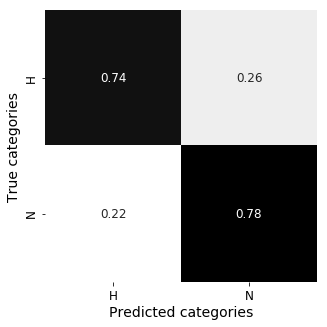

In [13]:
%%time
lr_model_w = lr_model
lr_model_w.fit(X_train_1M, y_train_1M)
y_preds_w = lr_model_w.predict(X_test_1M)

print(classification_report( y_test_1M, y_preds_w ))
cm_w = print_cm(y_test_1M, y_preds_w , ['H','N'])

#### Non-weighted features

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.18      0.62      0.28        73
        1.0       0.91      0.57      0.70       473

avg / total       0.81      0.58      0.64       546



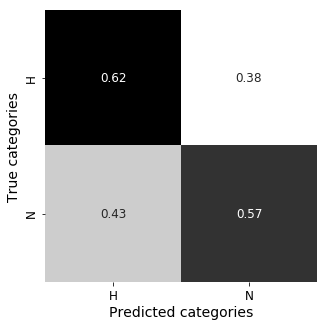

In [14]:
%%time
lr_model_uw = lr_model

lr_model_uw.fit(X_train_not_weighted, y_train_not_weighted)
y_preds_uw = lr_model_uw.predict(X_test_not_weighted)

print(classification_report( y_test_not_weighted, y_preds_uw ))
cm_uw = print_cm(y_test_not_weighted, y_preds_uw , ['H','N'])

#### Selected weighted features

             precision    recall  f1-score   support

        0.0       0.32      0.68      0.44        73
        1.0       0.94      0.78      0.85       473

avg / total       0.86      0.77      0.80       546



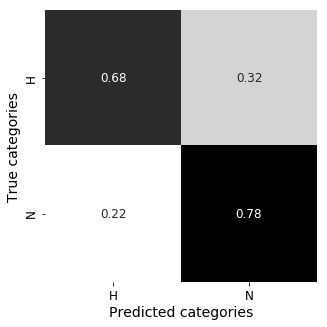

In [16]:
%%time
lr_model_sw = lr_model

lr_model_sw.fit(X_train_selected, y_train_selected)
y_preds_sw = lr_model_sw.predict(X_test_selected)

print(classification_report( y_test_selected, y_preds_sw ))
cm_sw = print_cm(y_test_selected, y_preds_sw , ['H','N'])

#### Tf-Idf only features

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

             precision    recall  f1-score   support

        0.0       0.65      0.44      0.52        73
        1.0       0.92      0.96      0.94       473

avg / total       0.88      0.89      0.88       546



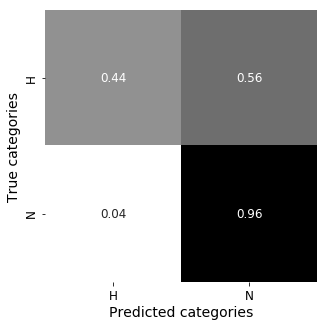

In [17]:
rf_model= ensemble.RandomForestClassifier(criterion='gini')

rf_model.fit(X_train_tfidf, y_train_tfidf)
y_preds_rf = rf_model.predict(X_test_tfidf)

print(classification_report( y_test_tfidf, y_preds_rf ))
cm_rf = print_cm(y_test_tfidf, y_preds_rf , ['H','N'])

#### Undersampling+Log Reg

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler(return_indices=True)
X_res, y_res, idx_res = rus.fit_sample(M_selected, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

X_res_train, X_res_test, y_res_train, y_res_test = train_test_split(X_res, 
                                                     y_res ,
                                                     random_state=42, 
                                                     test_size=0.1)

print(y_res_train.shape)
print(y_res_test.shape)

Resampled dataset shape Counter({0.0: 545, 1.0: 545})
(981,)
(109,)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

             precision    recall  f1-score   support

        0.0       0.73      0.79      0.76        56
        1.0       0.76      0.70      0.73        53

avg / total       0.74      0.74      0.74       109



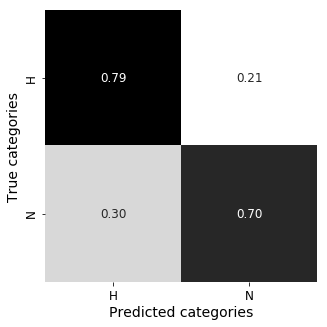

In [19]:
%%time
lr_model_us = lr_model

lr_model_us.fit(X_res_train, y_res_train)
y_preds_us = lr_model_us.predict(X_res_test)

print(classification_report( y_res_test, y_preds_us ))
cm_us = print_cm(y_res_test, y_preds_us , ['H','N'])

#### Result:
Weighted features seem to do better. So, the higher evaluation time is worth. 
Also, w2v with tf-idf weights does significantly better than Tf-Idf alone.
On the other hand, it is not completely clear if using selected features gives better performance.
In the following, we will optimize using w2v features with tf-idf weights, and compare features obtained from selected and full sample

### Grid parameter search
####  As a metric, we maximise recall for class "H" (it is better to predict an "H" which is actually an "N" than the contrary). The function custom_recall does this and will be used as evaluation metric to choose the best model 

In [ ]:
def custom_recall(y_true, y_pred): 
    ''' Computes recall only on labels 0 '''
    rec = recall_score(y_true, y_pred, labels=[0], pos_label=0, average='binary')
    return rec #target_accuracy

my_scorer = make_scorer(custom_recall)



def my_pipeline(my_clf, x_train, x_test , y_train, y_test, scorer, parameters):

    pipeline = Pipeline([('clf', my_clf)])

    nn = x_train.shape[0]

    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1,verbose=1, scoring=scorer)
    grid_search.fit(x_train, y_train)
    print ('Best score: %0.3f' % grid_search.best_score_)
    print ('Best parameters set:')
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print ('\t%s: %r' % (param_name, best_parameters[param_name]))

    predictions = grid_search.predict(x_test)
    print (classification_report(y_test, predictions))
    
    return grid_search

#### Logistic Regression - weighted features from full dataset

In [ ]:
lr_init = linear_model.LogisticRegression(C=1., class_weight='balanced',penalty='l1')

In [ ]:
%%time
parameters_lr = {
        #'clf__penalty': ('l1', 'l2'),
        'clf__C': np.linspace(1, 10, 2),
    }



class_LR_w = my_pipeline(lr_init, 
                       X_train_1M, X_test_1M, y_train_1M, y_test_1M,
                       my_scorer , parameters_lr)

In [ ]:
cm_w = print_cm(y_test_1M, class_LR_w.predict(X_test_1M) , ['H','N'])

#### Logistic Regression - weighted features from selected dataset

In [ ]:
%%time
parameters_lr = {
        #'clf__penalty': ('l1', 'l2'),
        'clf__C': np.linspace(1, 10, 2),
    }



class_LR_selected = my_pipeline(lr_init, 
                       X_train_selected, X_test_selected, y_train_selected, y_test_selected,
                       my_scorer , parameters_lr)

print_cm(y_test_selected, class_LR_selected.predict(X_test_selected) , ['H','N'])

In [ ]:
cm_selected = print_cm(y_test_selected, class_LR_w.predict(X_test_selected) , ['H','N'])

#### Logistic Regression - unweighted features from full dataset

In [ ]:
%%time
parameters_lr = {
        'clf__penalty': ('l1', 'l2'),
        'clf__C': np.linspace(1, 10, 2),
    }



class_LR_uw = my_pipeline(linear_model.LogisticRegression(C=1., 
                                                       class_weight='balanced'
                                                       ), 
                       X_train_not_weighted, X_test_not_weighted,
                          y_train_not_weighted, y_test_not_weighted,
                       my_scorer , parameters_lr)

print_cm(y_test_not_weighted, class_LR_uw.predict(X_test_not_weighted) , ['H','N'])

In [ ]:
cm_uw = print_cm(y_test_not_weighted, class_LR_uw.predict(X_test_not_weighted) , ['H','N'])

#### Random Forest + TFIDF features

In [ ]:
parameters_rf = {
        'clf__criterion': ('gini', 'entropy'),
        'clf__max_depth': (None, 10, 100),
        'clf__min_samples_leaf':(1,5,10)
    }

class_RF = my_pipeline(ensemble.RandomForestClassifier(n_jobs=-1, random_state=321),
                       X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf,
                       my_scorer, parameters_rf )

In [ ]:
cm_RF = print_cm(y_test_tfidf, class_RF.predict(X_test_tfidf) , ['H','N'])

#### Undersampling + Logistic Regression

In [ ]:
%%time
parameters_lr = {
       'clf__penalty': ('l1', 'l2'),
        'clf__C': np.linspace(1, 10, 2),
    }



class_LR_us = my_pipeline(linear_model.LogisticRegression(C=1.), 
                       X_res_train, X_res_test, y_res_train, y_res_test,
                       my_scorer , parameters_lr)

In [ ]:
print_cm(y_res_test, class_LR_us.predict(X_res_test) , ['H','N'])

##### Very promising but results can fluctuate a lot depending on the sampling. Must add k-fold cross validation !!

## Other trials (no luck)

#### SVM

In [ ]:
svm_model= svm.SVC(C=1, kernel='rbf', gamma=0.1)

svm_model.fit(X_train_1M, y_train_1M)
y_preds = svm_model.predict(X_test_1M)

print(classification_report( y_test_1M, y_preds ))
print_cm(y_test_1M, y_preds , ['H','N'])

#### Random Forest

In [ ]:
rf_model= ensemble.RandomForestClassifier(criterion='entropy', n_estimators=10)

rf_model.fit(X_train_1M, y_train_1M)
y_preds = rf_model.predict(X_test_1M)

print(classification_report( y_test_1M, y_preds ))
print_cm(y_test_1M, y_preds , ['H','N'])

In [ ]:

parameters_svm = {
        'clf__gamma': (0.0001, 0.001, 0.01),
        'clf__C': (100, 150, 500),
        #'clf__kernel':('rbf', 'linear','sigmoid' )
    }

class_SVM = my_pipeline(svm.SVC(C=100, kernel='rbf'),
                        X_train_1M, X_test_1M, y_train_1M, y_test_1M,
                       my_scorer , parameters_svm)

In [ ]:
print_cm(y_test_1M, class_SVM.predict(X_test_1M) , ['H','N'])

#### KNN

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=5, metric='chebyshev')

knn.fit(X_train_1M, y_train_1M)
y_pred_1M = knn.predict(X_test_1M)

print_cm(y_test_1M, y_pred_1M , ['H','N'])

In [ ]:
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier(n_neighbors=10, metric='minkowski')

knn.fit(X_res_train, y_res_train)
y_pred_us = knn.predict(X_res_test)

print_cm(y_res_test, y_pred_us , ['H','N'])

## Best model

Our conclusion: the best model is Logistic REgression with l1 reg. and C=1 .
It seem to work (slightly) better with  w2v trained on the full sample rather than on the selected sample (why? Because the selected sample it's trained with less data? ). However, the difference is tiny and more investigation seems important (e.g trying cross-validation).


If we use a Tf-Idf vectorizer, we get that the best classifier is a Random Forest with gini criterion. This does considerably worse that w2v+log reg if we consider the False positive rate (predicted =N but true=H ), and better if we consider the false negative (predicted=H but true=N). 
Since it's better to minimize false positive rate, we conclude that w2v works better.  

Finally, using undersampling techniques seems to improve the performace, in particular on the false positive rate, even if the size of the dataset is highly reduced. Given the small amount of data available, however, this risks to worsen the classifier's performance when applied to previously unseen data, and also the performance can fluctuate considerably when changing subsampling. However, this result is interesting to keep in mind if one has a larger dataset.

#### In general, to better comment performance we need to cross-validate ! Otherwise the results fluctuate too much (this is natural given the nature of the dataset)

In [ ]:
SAVED_MODEL = models_dir+"saved_lr_1M.pkl"
with open(SAVED_MODEL, "wb") as f:
    pickle.dump(class_LR, f)

SAVED_MODEL = models_dir+"saved_lr_selected.pkl"
with open(SAVED_MODEL, "wb") as f:
    pickle.dump(class_LR_selected, f)



<img src="https://datascientest.fr/train/assets/logo_datascientest.png", style="height:150px">

<hr style="border-width:2px;border-color:#75DFC1">
<h1 style = "text-align:center" > Practice Python </h1> 
<hr style="border-width:2px;border-color:#75DFC1">


* pour ajouter une cellule utiliser esc + a
* pour supprimer une cellule utiliser esc + x (faire attention)
